In [1]:
#%config IPCompleter.greedy = True
#%config Completer.use_jedi = False

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Theme
sns.set_theme(style='darkgrid')

First of all get all data and create a dataframe for them, I have included year, month and day
Next time, i will use some formula for making those calculations

In [140]:
myfile = "./data_v1.xlsx"
main_df = pd.read_excel(myfile)
main_df

,Date,Program,Visits,Revenue
0,2015-01-01 23:59:59,SEO,0,2317.14
1,2015-01-01 23:59:59,SEO,0,903.10
2,2015-01-01 23:59:59,SEO,2844,0.00
3,2015-01-01 23:59:59,Direct,0,24.31
4,2015-01-01 23:59:59,Direct,937,0.00
...,...,...,...,...
104788,2021-04-11 23:59:59,::unspecified::,14,0.00
104789,2021-04-11 23:59:59,Paid Social,179,0.00
104790,2021-04-11 23:59:59,Organic Social,143,0.00
104791,2021-04-11 23:59:59,Other,1,0.00


In [4]:
#Let's check if there is any NaN
main_df.isna().sum()

Date                 0
Program              0
Shop Visits (e36)    0
Revenue              0
dtype: int64

In [5]:
main_df.dtypes

Date                 datetime64[ns]
Program                      object
Shop Visits (e36)             int64
Revenue                     float64
dtype: object

In [134]:
data = main_df.copy()

In [127]:
def convert_dates(df, column):
    """
    DESCRIPTION
      This function returns a new DataFrame with a new Year, Month, Day and Year-Week column
    ARGUMENTS
      df: This is the DataFrame to manipulate
      column: The date column name
    RETURN
      A new DataFrame with 4 new columns related to the date
    """
        
    #This is the returned DataFrame
    data = pd.DataFrame()
    
    #This function retreives an isocalendar Series
    isocalendar = df[column].apply(lambda x: pd.to_datetime(x).isocalendar())
    #Get all ISO Year Series and ISO Week Series
    year = isocalendar.apply(lambda x: x[0])
    week = isocalendar.apply(lambda x: x[1])
    #Get Month Series and Day Series
    month = df[column].apply(lambda x: pd.to_datetime(x).month)
    day = df[column].apply(lambda x: pd.to_datetime(x).day)
    
    #Add the new columns
    data['Year'] = year
    data['Month'] = month
    data['Day'] = day
    data['Week'] = week
    
    #This creates the Year-Week concatenated Series and it is added to the DataFrame
    year_week = data.apply(lambda x: str(x['Year']) + '-0' + str(x['Week']) if x['Week'] < 10 else str(x['Year']) + '-' + str(x['Week']), axis = 1)
    data['Year-Week'] = year_week
    
    return pd.concat([data, df], axis = 1)    

In [182]:
new_data = convert_dates(main_df, 'Date')

In [142]:
new_data

,Year,Month,Day,Week,Year-Week,Date,Program,Visits,Revenue
0,2015,1,1,1,2015-01,2015-01-01 23:59:59,SEO,0,2317.14
1,2015,1,1,1,2015-01,2015-01-01 23:59:59,SEO,0,903.10
2,2015,1,1,1,2015-01,2015-01-01 23:59:59,SEO,2844,0.00
3,2015,1,1,1,2015-01,2015-01-01 23:59:59,Direct,0,24.31
4,2015,1,1,1,2015-01,2015-01-01 23:59:59,Direct,937,0.00
...,...,...,...,...,...,...,...,...,...
104788,2021,4,11,14,2021-14,2021-04-11 23:59:59,::unspecified::,14,0.00
104789,2021,4,11,14,2021-14,2021-04-11 23:59:59,Paid Social,179,0.00
104790,2021,4,11,14,2021-14,2021-04-11 23:59:59,Organic Social,143,0.00
104791,2021,4,11,14,2021-14,2021-04-11 23:59:59,Other,1,0.00


In [165]:
new_data = new_data[['Year', 'Week', 'Program', 'Visits', 'Revenue']]
new_data

,Year,Week,Program,Visits,Revenue
0,2015,1,SEO,0,2317.14
1,2015,1,SEO,0,903.10
2,2015,1,SEO,2844,0.00
3,2015,1,Direct,0,24.31
4,2015,1,Direct,937,0.00
...,...,...,...,...,...
104788,2021,14,::unspecified::,14,0.00
104789,2021,14,Paid Social,179,0.00
104790,2021,14,Organic Social,143,0.00
104791,2021,14,Other,1,0.00


In [183]:
new_data1 = new_data.groupby(['Year', 'Week', 'Program'])['Visits'].sum().unstack().reset_index()
new_data1

Program,Year,Week,::unspecified::,Affiliate,Apps,CSE,Direct,Display,Email,Lenovo Social,Microsite,Organic Social,Other,Paid Social,Preload,SEM,SEO,Social,Video Advertising,cse
0,2015,1,0.0,24.0,29.0,NaN,4585.0,0.0,106.0,NaN,NaN,0.0,NaN,NaN,130.0,0.0,15758.0,NaN,NaN,NaN
1,2015,2,0.0,35.0,71.0,NaN,11511.0,0.0,255.0,NaN,NaN,0.0,NaN,NaN,315.0,7431.0,37887.0,NaN,NaN,NaN
2,2015,3,1.0,25.0,62.0,NaN,9026.0,0.0,2805.0,NaN,NaN,0.0,NaN,NaN,306.0,9271.0,32474.0,NaN,NaN,NaN
3,2015,4,1.0,18.0,93.0,NaN,11847.0,0.0,369.0,NaN,NaN,0.0,NaN,NaN,318.0,8621.0,32102.0,NaN,NaN,NaN
4,2015,5,0.0,40.0,88.0,NaN,10722.0,0.0,220.0,NaN,NaN,0.0,NaN,NaN,309.0,8080.0,30395.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2021,10,108.0,9265.0,1396.0,1.0,104194.0,17660.0,2071.0,5.0,NaN,161.0,10.0,12787.0,NaN,23073.0,25314.0,NaN,NaN,NaN
324,2021,11,107.0,5397.0,1049.0,0.0,122004.0,23348.0,1635.0,13.0,NaN,255.0,10.0,11111.0,NaN,19056.0,25257.0,NaN,NaN,NaN
325,2021,12,108.0,5415.0,1048.0,0.0,157785.0,22555.0,1496.0,6.0,NaN,141.0,16.0,10604.0,NaN,16681.0,24952.0,NaN,NaN,NaN
326,2021,13,89.0,2863.0,628.0,0.0,107137.0,10051.0,1910.0,5.0,NaN,878.0,10.0,4827.0,NaN,14285.0,20554.0,NaN,NaN,NaN


In [184]:
new_data1.fillna(value = 0, inplace = True, axis = 0)
new_data1

Program,Year,Week,::unspecified::,Affiliate,Apps,CSE,Direct,Display,Email,Lenovo Social,Microsite,Organic Social,Other,Paid Social,Preload,SEM,SEO,Social,Video Advertising,cse
0,2015,1,0.0,24.0,29.0,0.0,4585.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0,15758.0,0.0,0.0,0.0
1,2015,2,0.0,35.0,71.0,0.0,11511.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,315.0,7431.0,37887.0,0.0,0.0,0.0
2,2015,3,1.0,25.0,62.0,0.0,9026.0,0.0,2805.0,0.0,0.0,0.0,0.0,0.0,306.0,9271.0,32474.0,0.0,0.0,0.0
3,2015,4,1.0,18.0,93.0,0.0,11847.0,0.0,369.0,0.0,0.0,0.0,0.0,0.0,318.0,8621.0,32102.0,0.0,0.0,0.0
4,2015,5,0.0,40.0,88.0,0.0,10722.0,0.0,220.0,0.0,0.0,0.0,0.0,0.0,309.0,8080.0,30395.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2021,10,108.0,9265.0,1396.0,1.0,104194.0,17660.0,2071.0,5.0,0.0,161.0,10.0,12787.0,0.0,23073.0,25314.0,0.0,0.0,0.0
324,2021,11,107.0,5397.0,1049.0,0.0,122004.0,23348.0,1635.0,13.0,0.0,255.0,10.0,11111.0,0.0,19056.0,25257.0,0.0,0.0,0.0
325,2021,12,108.0,5415.0,1048.0,0.0,157785.0,22555.0,1496.0,6.0,0.0,141.0,16.0,10604.0,0.0,16681.0,24952.0,0.0,0.0,0.0
326,2021,13,89.0,2863.0,628.0,0.0,107137.0,10051.0,1910.0,5.0,0.0,878.0,10.0,4827.0,0.0,14285.0,20554.0,0.0,0.0,0.0


In [193]:
new_data.groupby(['Year'])['Revenue'].sum().unstack().reset_index()


AttributeError: 'Int64Index' object has no attribute 'remove_unused_levels'

In [155]:
for i in new_data.columns:
    print(i, new_data[i].sum())

Year 211516075
Week 2976849
Visits 30655972
Revenue 58998047.12113334
Program_::unspecified:: 1981
Program_Affiliate 15317
Program_Apps 3238
Program_CSE 217
Program_Direct 16954
Program_Display 3139
Program_Email 4621
Program_Lenovo Social 1804
Program_Microsite 7
Program_Organic Social 2336
Program_Other 684
Program_Paid Social 2126
Program_Preload 888
Program_SEM 24266
Program_SEO 26878
Program_Social 14
Program_Video Advertising 28
Program_cse 295


In [161]:
new_data['Program_Affiliate'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [143]:
#Make a copy of the main dataframe
data = new_data[['Program','Year','Month','Day','Visits','Revenue']]

In [8]:
#For this early stage I discard type of Traffic and just sum all of them
data = data.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()

In [9]:
#Reset Index after having made a groupby
data = data.reset_index()

In [10]:
#Lets check it out how this looks like and we can see that we have 2223 rows of data. Original one was 100,033 rows
data

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2218,2021,1,27,39461,36720.96
2219,2021,1,28,41043,30386.56
2220,2021,1,29,39174,65198.11
2221,2021,1,30,29582,33134.80


Let's check the Variability of Pearson
 * High Variability in Revenue
 * Visit Variability is less than Revenue but it is above 0.5


In [11]:
#High Variability in Revenue
pearson_revenue = data['Revenue'].std() / data['Revenue'].mean()
#Visit Variability is less than Revenue but it is above 0.5
pearson_traffic = data['Visits'].std() / data['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue}) and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 1.53995483973178) and Pearson Visits: 0.6361548377691404


In [12]:
data['Revenue'].describe()

count      2223.000000
mean      25438.899731
std       39174.756758
min           0.000000
25%        9351.615000
50%       18048.570000
75%       31929.080000
max      858333.560000
Name: Revenue, dtype: float64

In [13]:
#There are number way above 100.000. Those are some outliners
sorted(data['Revenue'], reverse=True)

[858333.5600000034,
 784321.290000003,
 590327.1899999998,
 563812.3999999989,
 529061.6699999995,
 334605.57000000076,
 311593.59999999957,
 304644.9999999996,
 206742.70999999996,
 192917.33000000007,
 191231.44000000012,
 187432.28999999983,
 186791.86000000004,
 171407.57999999987,
 169560.74000000005,
 167811.78999999986,
 153453.7500000001,
 139222.25999999998,
 132259.49000000002,
 132244.95,
 131383.15999999992,
 130645.76999999989,
 124783.69999999997,
 124024.70000000022,
 117069.57999999999,
 115680.39000000003,
 112899.65000000001,
 111940.03999999998,
 109272.9500000002,
 107702.02999999996,
 107599.70999999995,
 104098.95000000004,
 101380.1800000001,
 100517.25999999995,
 98058.94000000002,
 97243.22999999998,
 95266.08000000016,
 94826.27,
 93087.03000000006,
 92653.50999999995,
 92156.65000000002,
 91074.79,
 90887.97000000009,
 90056.15,
 89374.43000000004,
 88473.35000000008,
 87368.04000000008,
 86168.33999999995,
 84098.13000000002,
 83723.62,
 82678.79,
 81664.65,

(array([ 54., 100., 120., 154., 177., 143., 126., 110., 124., 115.,  95.,
         81.,  79.,  63.,  61.,  66.,  61.,  51.,  55.,  41.,  35.,  26.,
         35.,  34.,  32.,  13.,  15.,  17.,  11.,  10.,  14.,   9.,   6.,
         13.,   2.,   6.,   5.,   4.,   5.,   1.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   2.,   1.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

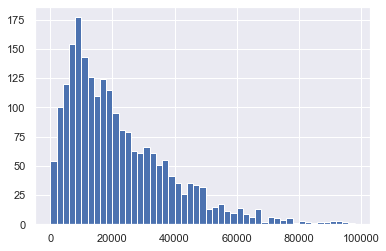

In [14]:
plt.hist(data['Revenue'], bins=range(0,100000,2000))

(array([3., 3., 2., 2., 2., 0., 4., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
        2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000,
        140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000,
        180000, 185000, 190000, 195000, 200000, 20

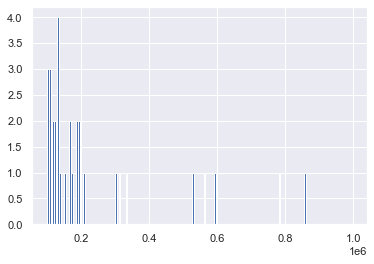

In [15]:
#Let's see the outliners
plt.hist(data['Revenue'], bins=range(100000,1000000,5000))

In [16]:
#We have 34 outliners out of more than 2000 records
data[data['Revenue'] > 100000]['Revenue'].value_counts().sum()

34

In [17]:
data['Visits'].describe()

count      2223.000000
mean      12871.529015
std        8188.285452
min         245.000000
25%        7774.000000
50%        9969.000000
75%       14886.000000
max      109148.000000
Name: Visits, dtype: float64

In [18]:
data['Visits'].max()

109148

(array([  1.,   9., 159., 449., 501., 309., 190.,  92.,  84.,  88.,  77.,
         48.,  55.,  28.,  25.,  31.,  10.,  10.,   7.,   9.,  15.,  11.,
          6.,   2.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

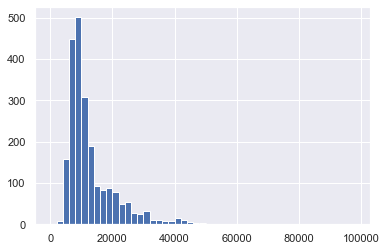

In [19]:
plt.hist(data['Visits'], bins=range(0,100000,2000))

In [20]:
#Let's see the correlation across the variables
data.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.044018,0.001226,0.659991,0.305776
Month,-0.044018,1.000000,0.009158,0.168876,0.128174
Day,0.001226,0.009158,1.000000,0.074226,0.088392
Visits,0.659991,0.168876,0.074226,1.000000,0.591148
Revenue,0.305776,0.128174,0.088392,0.591148,1.000000


In [21]:
#Now let's try to apply log to the variables, except when the value is 0 (inf.)
data_log = pd.DataFrame(np.log(data[data['Revenue'] != 0]))

In [22]:
#Now we can see a different correlation matrix. Visits still quite correlate with Revenue but Year as well
data_log.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.063566,0.001097,0.732171,0.604629
Month,-0.063566,1.000000,0.005938,0.092400,0.109626
Day,0.001097,0.005938,1.000000,0.054783,0.076481
Visits,0.732171,0.092400,0.054783,1.000000,0.675325
Revenue,0.604629,0.109626,0.076481,0.675325,1.000000


In [23]:
#Bear in mind that we are using Log e and therefore Pearson results are different
pearson_revenue = data_log['Revenue'].std() / data_log['Revenue'].mean()
pearson_traffic = data_log['Visits'].std() / data_log['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue} and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 0.09859521582003562 and Pearson Visits: 0.05443959700737877


In [24]:
data_log['Revenue'].describe()

count    2217.000000
mean        9.720446
std         0.958389
min         3.837730
25%         9.153696
50%         9.804346
75%        10.374114
max        13.662748
Name: Revenue, dtype: float64

(array([  0.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   3.,   0.,   2.,   1.,   4.,   5.,   6.,  12.,  18.,  29.,
         35.,  52.,  59., 111., 134., 174., 176., 207., 244., 204., 212.,
        208., 143.,  79.,  41.,  20.,  10.,   6.,   7.,   1.,   2.,   1.,
          0.,   3.,   0.,   2.,   0.]),
 array([ 3.        ,  3.2244898 ,  3.44897959,  3.67346939,  3.89795918,
         4.12244898,  4.34693878,  4.57142857,  4.79591837,  5.02040816,
         5.24489796,  5.46938776,  5.69387755,  5.91836735,  6.14285714,
         6.36734694,  6.59183673,  6.81632653,  7.04081633,  7.26530612,
         7.48979592,  7.71428571,  7.93877551,  8.16326531,  8.3877551 ,
         8.6122449 ,  8.83673469,  9.06122449,  9.28571429,  9.51020408,
         9.73469388,  9.95918367, 10.18367347, 10.40816327, 10.63265306,
        10.85714286, 11.08163265, 11.30612245, 11.53061224, 11.75510204,
        11.97959184, 12.20408163, 12.42857143, 12.65306122, 12.87755102,
       

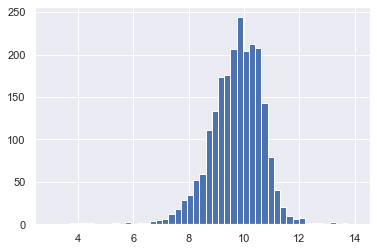

In [25]:
plt.hist(data_log['Revenue'], bins=np.linspace(start=3,stop=14,num=50))

In [26]:
data_log['Visits'].describe()

count    2217.000000
mean        9.320332
std         0.507395
min         8.148156
25%         8.960468
50%         9.208238
75%         9.609787
max        11.600460
Name: Visits, dtype: float64

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   7.,  12.,  38.,  66.,  67., 110., 195., 215., 217., 251.,
        180., 131., 122.,  71.,  66.,  87.,  86.,  66.,  63.,  37.,  48.,
         14.,  19.,  26.,  12.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.]),
 array([ 7.        ,  7.10204082,  7.20408163,  7.30612245,  7.40816327,
         7.51020408,  7.6122449 ,  7.71428571,  7.81632653,  7.91836735,
         8.02040816,  8.12244898,  8.2244898 ,  8.32653061,  8.42857143,
         8.53061224,  8.63265306,  8.73469388,  8.83673469,  8.93877551,
         9.04081633,  9.14285714,  9.24489796,  9.34693878,  9.44897959,
         9.55102041,  9.65306122,  9.75510204,  9.85714286,  9.95918367,
        10.06122449, 10.16326531, 10.26530612, 10.36734694, 10.46938776,
        10.57142857, 10.67346939, 10.7755102 , 10.87755102, 10.97959184,
        11.08163265, 11.18367347, 11.28571429, 11.3877551 , 11.48979592,
       

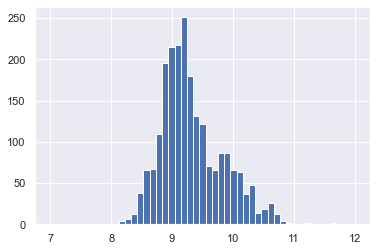

In [27]:
plt.hist(data_log['Visits'], bins=np.linspace(start=7,stop=12,num=50))

In [28]:
#This is a new DataFrame 
data_by_year_month = data.groupby(['Year','Month'])[['Visits','Revenue']].sum()
data_by_year_month = data_by_year_month.reset_index()

In [29]:
def back_poly_parameters(l,i,x):
    """
    DESCRIPTION
      This function return a vector of coefficients for plotting easily. It is using backtracking
    ARGUMENTS
      l: list of coefficients from np.polyfit, it does not matter the degree
      i: This is the len of the list
      x: It is the X parameter
    RETURN
      A value p[0] * x**deg + ... + p[deg]
    """
    if i == 0:
        return 0
    else:
        #Empiezo de atrás hacia adelante porque el primer polinomio es x^y...hasta b
        #Si el índice tiene 3 elementos entonces x²+x+b y así sucesivamente
        return l[-i]*x**(i-1) + back_poly_parameters(l,i-1,x)

In [43]:
x = data_by_year_month.index
#Lets prepare a polynomial regression line for Revenue
y_revenue = data_by_year_month['Revenue']
d_r = 4 #This is the degree for the polynomial
list_revenue = np.polyfit(x, y_revenue, d_r)

#Lets prepare a polynomial regression line for Revenue
y_visits = data_by_year_month['Visits']
d_v = 4 #This is the degree for the polynomial
list_visits = np.polyfit(x, y_visits, d_v)

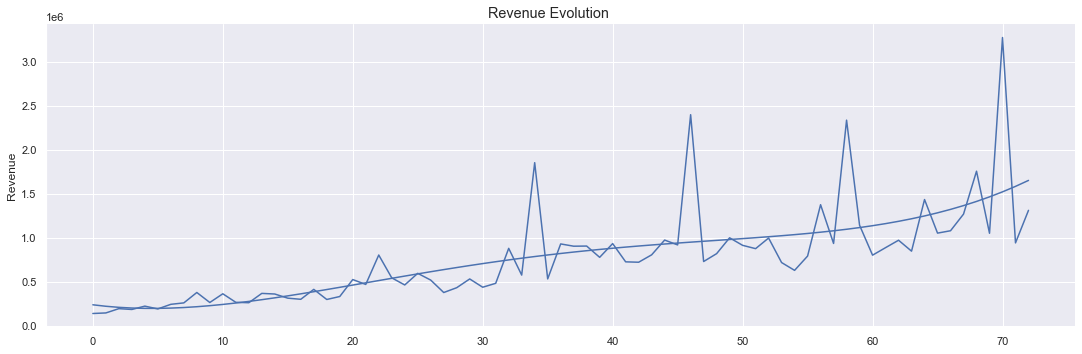

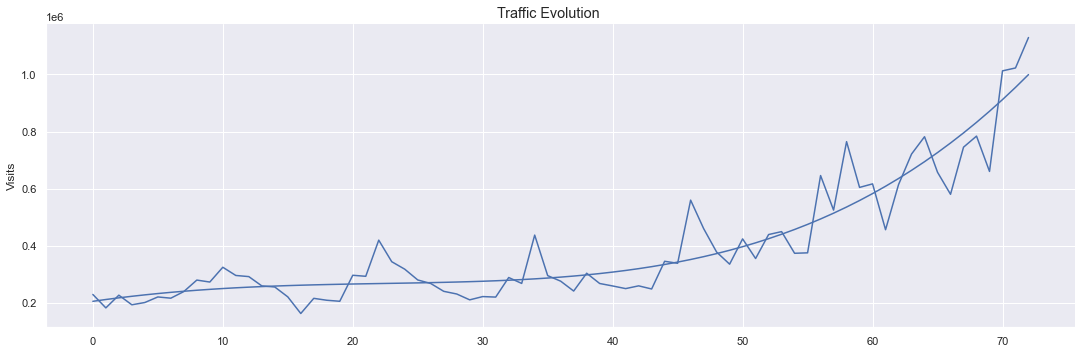

In [44]:
#Here we can see the trend across the months in Revenue and Visits and we draw another line.
#Actually that line is a polynomial line, in the Revenue case, it is a pure line because degree=2 does not
#Show any difference. However, the Visits chart is adjusting much better with a degree=2 or even 3
g = sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Revenue', kind='line', aspect=3).fig.suptitle('Revenue Evolution')
plt.plot(x, back_poly_parameters(list_revenue, len(list_revenue), x))
#plt.axvline(100, color="r", linestyle="--");
sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Visits', kind='line', aspect=3).fig.suptitle('Traffic Evolution')
plt.plot(x, back_poly_parameters(list_visits, len(list_visits), x))

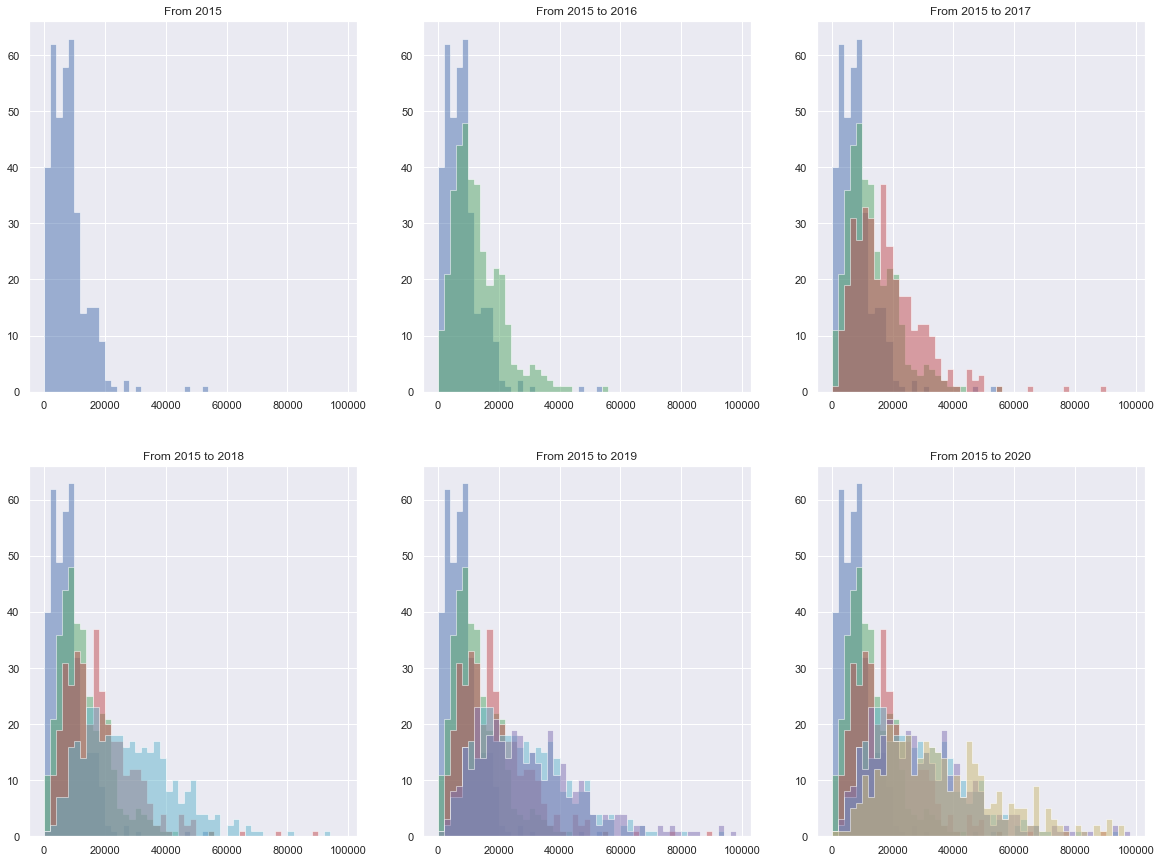

In [32]:
#It seems the Revenue distribution follows a Gamma Distribution even when you add the rest of the years
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,100000,2000), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Revenue', 'Year', data['Year'].unique(), ax)

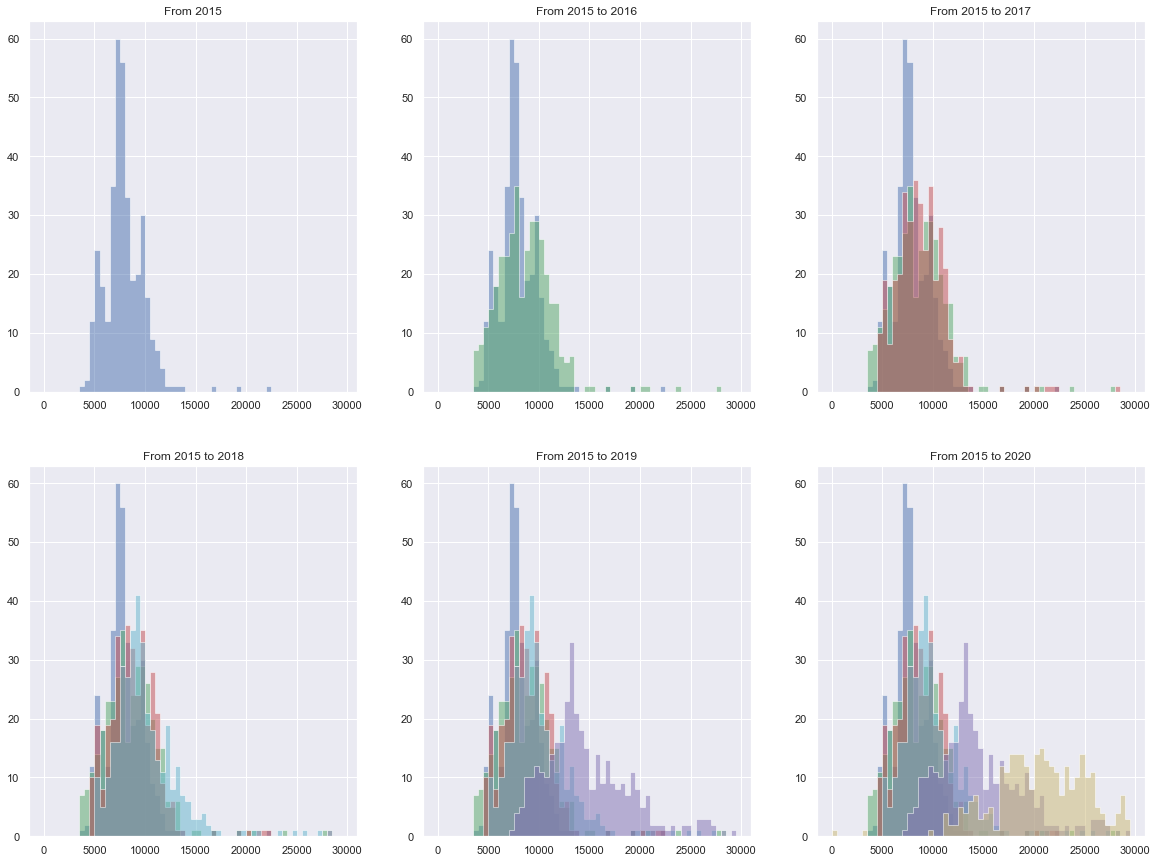

In [33]:
#Traffic seems a Norm Distribution but when you add more years it seems a Gamma Distribution but every year
#Seems centrated. Further analysis are needed
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,30000,500), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Visits', 'Year', data['Year'].unique(), ax)

In [34]:
np.median(data['Revenue'])

18048.57

In [35]:
np.mean(data['Revenue'])

25438.899730604302

In [36]:
data['Revenue'].kurtosis()

206.35291518972994

In [37]:
data['Visits'].kurtosis()
#Leptocurtica

12.811651479904462

In [38]:
data['Revenue'].skew()
#Asimétrica a la derecha

12.066027764425613

In [39]:
data['Visits'].skew()

2.5753619816927293

In [40]:
from sklearn.metrics import r2_score